# Comparison of ML model and OGGM, PYGEM, GLOGEM on point mass balance

In [209]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde

import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results

## Classes

#### Custom loss/objective function scikit learn api with metadata

To be used with custom XGBRegressor class

In [210]:
# Custom objective function scikit learn api with metadata, to be used with custom XGBRegressor class

def custom_mse_metadata(y_true, y_pred, metadata):
    """
    Custom Mean Squared Error (MSE) objective function for evaluating monthly predictions with respect to 
    seasonally or annually aggregated observations.
    
    For use in cases where predictions are done on a monthly time scale and need to be aggregated to be
    compared with the true aggregated seasonal or annual value. Aggregations are performed according to a
    unique ID provided by metadata. The function computes gradients and hessians 
    used in gradient boosting methods, specifically for use with the XGBoost library's custom objective 
    capabilities.
    
    Parameters
    ----------
    y_true : numpy.ndarray
        True (seasonally or annually aggregated) values for each instance. For a unique ID, 
        values are repeated n_months times across the group, e.g. the annual mass balance for a group
        of 12 monthly predictions with the same unique ID is repeated 12 times. Before calculating the 
        loss, the mean over the n unique IDs is taken.
    
    y_pred : numpy.ndarray
        Predicted monthly values. These predictions will be aggregated according to the 
        unique ID before calculating the loss, e.g. 12 monthly predictions with the same unique ID is
        aggregated for evaluation against the true annual value.
    
    metadata : numpy.ndarray
        An ND numpy array containing metadata for each monthly prediction. The first column is mandatory 
        and represents the ID of the aggregated group to which each instance belongs. Each group identified 
        by a unique ID will be aggregated together for the loss calculation. The following columns in the 
        metadata can include additional information for each instance that may be useful for tracking or further 
        processing but are not used in the loss calculation, e.g. number of months to be aggregated or the name 
        of the month.
        
        ID (column 0): An integer that uniquely identifies the group which the instance belongs to.
            
    Returns
    -------
    gradients : numpy.ndarray
        The gradient of the loss with respect to the predictions y_pred. This array has the same shape 
        as y_pred.
    
    hessians : numpy.ndarray
        The second derivative (hessian) of the loss with respect to the predictions y_pred. For MSE loss, 
        the hessian is constant and thus this array is filled with ones, having the same shape as y_pred.
    """
    
    # Initialize empty arrays for gradient and hessian
    gradients = np.zeros_like(y_pred)
    hessians = np.ones_like(y_pred) # Ones in case of mse
    
    # Unique aggregation groups based on the aggregation ID
    unique_ids = np.unique(metadata[:, 0])
    
    # Loop over each unique ID to aggregate accordingly
    for uid in unique_ids:
        # Find indexes for the current aggregation group
        indexes = metadata[:, 0] == uid
        
        # Aggregate y_pred for the current group
        y_pred_agg = np.sum(y_pred[indexes])
        
        # True value is the same repeated value for the group, so we can use the mean
        y_true_mean = np.mean(y_true[indexes])
        
        # Compute gradients for the group based on the aggregated prediction
        gradient = y_pred_agg - y_true_mean
        gradients[indexes] = gradient

    return gradients, hessians

#### Custom estimator class based on XGBRegressor

Inherits from xgboost.XGBRegressor 

Note/to-do: Modify def __init__(self,..) to retrieve kwarg for number of columns of metadata (n_metadata) with default n_metadata=None, to allow for flexibility in the number of metadata columns.

In [211]:
from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted

class CustomXGBRegressor(XGBRegressor):
    """
    CustomXGBRegressor is an extension of the XGBoost regressor that incorporates additional metadata into the learning process. The estimator
    is tailored to handle training datasets where the last three columns are metadata rather than features.
    
    The metadata is utilized in a custom mean squared error function. This function calculates gradients and hessians incorporating metadata, 
    allowing the model to learn from both standard feature data and additional information provided as metadata.
    
    The custom objective closure captures metadata along with the target values and predicted values to compute the gradients and hessians needed
    for the XGBoost training process.

    The class contains a custom score function (custom mse) that is used in GridSearchCV to evaluate validation performance for each fold.
    This is the default scorer for the class.
    
    Parameters inherited from XGBRegressor are customizable and additional parameters can be passed via kwargs, which will be handled by the
    XGBRegressor's __init__ method.
    
    Examples
    --------
    >>> model = CustomXGBRegressor(n_estimators=500, learning_rate=0.05)
    >>> model.fit(X_train, y_train)  # X_train includes metadata as the last 3 columns
    >>> predictions = model.predict(X_test)  # X_test includes metadata as the last 3 columns
    
    Note: CustomXGBRegressor requires a custom MSE function, `custom_mse_metadata`, which computes the gradient and hessian using additional metadata.
    """
    
    def __init__(self, metadata_shape=3, **kwargs):
        self.metadata_shape = metadata_shape
        super().__init__(**kwargs)

    def fit(self, X, y, **fit_params):
        # Split features from metadata
        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]

        # Define closure that captures metadata for use in custom objective
        def custom_objective(y_true, y_pred):
            return custom_mse_metadata(y_true, y_pred, metadata)

        # Set custom objective
        self.set_params(objective=custom_objective)

        # Call fit method from parent class (XGBRegressor)
        super().fit(features, y, **fit_params)

        return self

    def predict(self, X):
        # Check if the model is fitted
        check_is_fitted(self)
        
        features = X[:, :-self.metadata_shape]
        
        return super().predict(features)

    def score(self, X, y, sample_weight=None):

        y_pred = self.predict(X)

        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]
        
        all_pred_agg = []
        all_true_mean = []
    
        unique_ids = np.unique(metadata[:, 0]) # ID is first column of metadata

        # Loop over each unique ID to aggregate/get mean
        for uid in unique_ids:

            indexes = metadata[:, 0] == uid
        
            # Aggregate predictions for the current ID
            y_pred_agg = np.sum(y_pred[indexes])
        
            # Get mean of true values for the current ID
            y_true_mean = np.mean(y[indexes])

            all_pred_agg.append(y_pred_agg)
            all_true_mean.append(y_true_mean)
        
            #mse += (y_pred_agg - y_true_mean) ** 2

        all_pred_agg = np.array(all_pred_agg)
        all_true_mean = np.array(all_true_mean)

        # Compute mse 
        mse = ((all_pred_agg - all_true_mean) ** 2).mean()

        return -mse # Return negative because GridSearchCV maximizes score        


## Helper functions

In [165]:
# Get modelled mass balance from xarray Dataset based on 
# dataframe of point mass balances

def get_modelled_mb(df, ds, type):
    """
    df : pd.DataFrame of point mb (mass balance)
    ds : xr.DataSet of modelled mass balance
    type : str, variable in ds; 'mb_annual', 'mb_summer', or 'mb_winter'
    """
    
    mb_modelled = []

    # Loop through each row of df to extract modelled mb for the given ID, year, and nearest elevation
    for row in df.itertuples(index=False):

        # Use the attributes of namedtuple
        current_year = str(row.year) + '-10-01'
        current_altitude = row.altitude
        current_id = str(row.ID)
        current_year_dt = np.datetime64(current_year)

        # Check if the current_year_dt is in the 'time' coordinate of the dataset
        if current_year_dt in ds['time'].values:

            # Find nearest elevation to point
            nearest_elevation_idx = abs(ds['elevation'] - current_altitude).argmin()
            nearest_elevation = ds['elevation'][nearest_elevation_idx]

            # Check if current_id exists in the 'ID' coordinate of the dataset
            if current_id in ds['ID'].values:

                mb_val = ds[type].sel(
                    ID=current_id, time=current_year_dt, elevation=nearest_elevation).values

                mb_val = mb_val.item()
            else:
                mb_val = np.nan
        else:
            # If modelled mb is not available for the current year, use nan
            mb_val = np.nan

        mb_modelled.append(mb_val)

    return mb_modelled


In [215]:
# Get true values (means) and predicted values (aggregates)

def get_ytrue_y_pred_agg(y_true, y_pred, X):
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [216]:
def get_ytrue_y_pred_agg_season(y_true, y_pred, X, months=12):

    # Get values for the given season
    mask = X[:, -2] == months  
    X = X[mask] 
    
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

## Plotting functions

In [199]:
# Plot modelled and observed point mass balances

def plot_point_modelled(df, model, start_yr, end_yr):

    """
    df : pd.Dataframe of point mb
    type : str, variable in ds; 'netto', 'summer' or 'winter'
    model : str, model name; 'glogem', 'oggm', 'pygem'
    """

    df_clean_dropna = df.dropna(subset=['mb_'+model])

    df_clean = df_clean_dropna[(df_clean_dropna['year'] >= start_yr) & (df_clean_dropna['year'] <= end_yr)]

    y_data = df_clean['mb_'+model]
    x_data = df_clean['balance']
    
    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)

    df_with_density = pd.DataFrame({
        'x': x_data,
        'y': y_data,
        'z': z
        })

    df_with_density.sort_values('z', inplace=True)

    fig, ax = plt.subplots()
    scatter = ax.scatter(df_with_density['x'], df_with_density['y'], c=df_with_density['z'], s=50, cmap='viridis')

    max_val = max(x_data.max(), y_data.max())+0.5
    min_val = min(x_data.min(), y_data.min())-0.5
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('mb stake (m w.e.)')
    ax.set_ylabel('mb modelled elev band (m w.e.)')
    plt.title('Stake vs. ' + model)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_data, x_data))
    mae = mean_absolute_error(y_data, x_data) 
    r2 = r2_score(y_data, x_data) 
    count = len(x_data)  # Count the number of data points
    
    stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    
    #plt.legend()
    plt.colorbar(ax.collections[0], ax=ax, label='Density')
    plt.tight_layout()
    plt.grid(alpha=0.5)
    plt.show()

    #max_val = max(df_clean['mb_'+model].max(), df_clean['balance_'+type].max())
    #min_val = min(df_clean['mb_'+model].min(), df_clean['balance_'+type].min())

    #ax.set_xlim(min_val * 1.05, max_val +0.5)
    #ax.set_ylim(min_val * 1.05, max_val +0.5)

    #ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    #ax.set_aspect('equal', adjustable='box')

    #ax.set_xlabel('mb_modelled_elev_band')
    #ax.set_ylabel('mb_stake')
    #ax.legend(title='ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.title('Stake ' + type + ' vs. '+ model)

    # Calculate metrics
    #rmse = np.sqrt(mean_squared_error(df_clean['balance_'+ type], df_clean['mb_'+ model]))
    #mae = mean_absolute_error(df_clean['balance_' + type], df_clean['mb_'+ model])
    #r2 = r2_score(df_clean['balance_' + type], df_clean['mb_'+ model])
    #count = len(df_clean)  # Count the number of data points

    #stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}'
    #ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
    #    verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

    #plt.tight_layout()
    #plt.show()

    #print(f"Root Mean Squared Error (RMSE): {rmse}")
    #print(f"Mean Absolute Error (MAE): {mae}")
    #print(f"R-squared (R^2): {r2}")

In [220]:
def plot_prediction_per_season(y_test_all, y_pred_all, season='Annual'):

    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
    
    figsize=(5,5)
    fontsize=16
    s= 20
    n_toplot=10**10
    
    idxs = np.arange(len(y_test_all))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y_test_all.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y_pred_all.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    fig = plt.figure(figsize=figsize, dpi=100)
    plt.title(season + " mass balance", fontsize=20)
    plt.ylabel('Modeled mass balance (m w.e)', fontsize=fontsize)
    plt.xlabel('Observed mass balance (m w.e)', fontsize=fontsize)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=s)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    #plt.colorbar(sc) 
    lineStart = y_min
    lineEnd = y_max
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.axvline(0.0, ls='-.', c='k')
    plt.axhline(0.0, ls='-.', c='k')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (root_mean_squared_error(y_expected, y_predicted), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, ), ),
    r'$MAE=%.2f$' % (mean_absolute_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

## Get test dataset of monthly values 

13 glaciers: [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

- 54: 189 points
- 703: 30 points
- 941: 70 points
- 1135: 
- 1280: 71 points
- 2085: 
- 2320: 83 points
- 2478: 89 points
- 2769: 121 points
- 3133: 38 points
- 3137: 65 points
- 3138: 6 points
- 3141: 72 points

In [169]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_test.csv'

# Load data.
df_test_final = pd.read_csv(filepath + filename, index_col=0)

In [170]:
df_test_final

,id,BREID,RGIID,year,altitude_diff,altitude,altitude_climate,balance,aspect,slope,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159
1,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054
2,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977
3,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691
4,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12775,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567
12776,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162
12777,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537
12778,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390


In [171]:
# Drop strange winter mb value for 2768
idx_remove = df_test_final['balance'].idxmax()

print(df_test_final.iloc[idx_remove])

df_test_final = df_test_final.drop(idx_remove)
df_test_final.reset_index(drop=True, inplace=True)

id                             980
BREID                         3141
RGIID               RGI60-08.02969
year                          2009
altitude_diff          -384.967311
altitude                    1431.0
altitude_climate       1046.032689
balance                      -1.76
aspect                     3.23201
slope                     0.039335
n_months                         5
month                          may
t2m                     275.852234
sshf                    110641.375
slhf                      -88520.5
ssrd                    18400272.0
fal                       0.811642
str                     -2001006.0
tp                        0.007229
Name: 4900, dtype: object


In [172]:
# Add column for short form RGIID for retreival of model results
df_test_final['ID'] = df_test_final['RGIID'].str[-4:] # Short form of RGIID

In [173]:
df_test_final.ID = df_test_final.ID.astype(int)
df_test_final

,id,BREID,RGIID,year,altitude_diff,altitude,altitude_climate,balance,aspect,slope,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp,ID
0,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159,1258
1,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054,1258
2,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977,1258
3,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691,1258
4,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449,1258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24912,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567,2969
24913,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162,2969
24914,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537,2969
24915,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390,2969


### Get targets and features for ML model

In [242]:
# Select features for test
df_test_X_reduce = df_test_final.drop(['balance','year','BREID','RGIID', 'ID','altitude','altitude_climate'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_test_X = df_test_X_reduce[[c for c in df_test_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for test
df_test_y = df_test_final[['balance']]

# Get arrays of features+metadata and targets
X_test, y_test = df_test_X.values, df_test_y.values

In [243]:
df_test_X_reduce

,id,altitude_diff,aspect,slope,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,-129.772081,0.629597,0.278773,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159
1,0,-129.772081,0.629597,0.278773,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054
2,0,-129.772081,0.629597,0.278773,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977
3,0,-129.772081,0.629597,0.278773,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691
4,0,-129.772081,0.629597,0.278773,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24912,3092,-160.580241,2.906044,0.131717,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567
24913,3092,-160.580241,2.906044,0.131717,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162
24914,3092,-160.580241,2.906044,0.131717,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537
24915,3092,-160.580241,2.906044,0.131717,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390


### Get dataframes of annual, summer and winter mass balances for comparison

In [176]:
df_test_final

,id,BREID,RGIID,year,altitude_diff,altitude,altitude_climate,balance,aspect,slope,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp,ID
0,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159,1258
1,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054,1258
2,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977,1258
3,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691,1258
4,0,54,RGI60-08.01258,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449,1258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24912,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567,2969
24913,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162,2969
24914,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537,2969
24915,3092,3141,RGI60-08.02969,2017,-160.580241,1078.0,917.419759,-3.29,2.906044,0.131717,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390,2969


In [177]:
df_test_annual = df_test_final[df_test_final['n_months']==12]
df_test_annual = df_test_annual.groupby(by=['id']).mean() 
df_test_annual

C:\Users\kasj\AppData\Local\Temp\ipykernel_21032\4077999050.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_annual = df_test_annual.groupby(by=['id']).mean()


,BREID,year,altitude_diff,altitude,altitude_climate,balance,aspect,slope,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID
id,,,,,,,,,,,,,,,,,
2028,54.0,2013.0,-129.772081,471.0,341.227919,-4.92,0.629597,0.278773,12.0,273.045766,-10104.210938,-1.192698e+06,8.000492e+06,0.534814,-2.960371e+06,0.003176,1258.0
2029,54.0,2014.0,-97.772081,439.0,341.227919,-2.67,0.585924,0.296590,12.0,272.938726,225771.765625,-8.952235e+05,7.755540e+06,0.585304,-2.756938e+06,0.003372,1258.0
2030,54.0,2015.0,-102.772081,444.0,341.227919,-3.41,0.663261,0.302508,12.0,272.849403,133388.494792,-9.804107e+05,7.343682e+06,0.556681,-2.772570e+06,0.003141,1258.0
2031,54.0,2016.0,-102.772081,444.0,341.227919,-3.59,0.663261,0.302508,12.0,273.300074,-14896.781250,-1.064662e+06,7.145984e+06,0.540813,-2.628417e+06,0.003110,1258.0
2032,54.0,2017.0,-126.772081,468.0,341.227919,-2.46,0.836757,0.309196,12.0,272.918989,279420.552083,-7.474015e+05,7.817598e+06,0.538918,-2.767568e+06,0.003548,1258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,3141.0,2012.0,-160.580241,1078.0,917.419759,-2.07,2.906044,0.131717,12.0,274.500407,-340938.494792,-8.186743e+05,8.780470e+06,0.547067,-2.065823e+06,0.008703,2969.0
3089,3141.0,2013.0,-160.580241,1078.0,917.419759,-3.15,2.906044,0.131717,12.0,272.949669,-419158.447917,-1.114851e+06,9.078827e+06,0.541262,-2.491021e+06,0.006297,2969.0
3090,3141.0,2015.0,-161.580241,1079.0,917.419759,-2.61,2.906044,0.131717,12.0,274.638379,-144798.453125,-6.082808e+05,8.741161e+06,0.560521,-1.893852e+06,0.009249,2969.0


In [178]:
df_test_winter = df_test_final[df_test_final['n_months']==7]
df_test_winter = df_test_winter.groupby(by=['id']).mean() 
df_test_winter

C:\Users\kasj\AppData\Local\Temp\ipykernel_21032\3206729110.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_winter = df_test_winter.groupby(by=['id']).mean()


,BREID,year,altitude_diff,altitude,altitude_climate,balance,aspect,slope,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID
id,,,,,,,,,,,,,,,,,
1028,54.0,2013.0,-129.772081,471.0,341.227919,1.32,0.629597,0.278773,7.0,266.705911,800105.232143,62438.500000,3.477078e+06,0.749392,-2.148801e+06,0.003397,1258.0
1029,54.0,2014.0,-97.772081,439.0,341.227919,1.68,0.585924,0.296590,7.0,267.740727,996367.901786,65465.714286,3.052352e+06,0.758143,-2.145037e+06,0.003847,1258.0
1030,54.0,2015.0,-102.772081,444.0,341.227919,0.76,0.663261,0.302508,7.0,267.579795,946459.196429,21334.214286,3.186665e+06,0.750785,-2.258321e+06,0.002979,1258.0
1031,54.0,2016.0,-102.772081,444.0,341.227919,0.78,0.663261,0.302508,7.0,267.811977,868039.937500,102229.642857,3.540237e+06,0.771447,-2.084224e+06,0.003243,1258.0
1032,54.0,2017.0,-126.772081,468.0,341.227919,1.59,0.836757,0.309196,7.0,268.226903,856574.433036,64772.571429,3.494867e+06,0.679859,-2.391737e+06,0.003806,1258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,3141.0,2012.0,-160.580241,1078.0,917.419759,1.50,2.906044,0.131717,7.0,270.836827,23270.491071,-171713.642857,4.804682e+06,0.683440,-1.769234e+06,0.010046,2969.0
2024,3141.0,2013.0,-160.580241,1078.0,917.419759,1.14,2.906044,0.131717,7.0,267.233730,125356.500000,-123023.142857,5.492646e+06,0.711911,-2.165743e+06,0.006262,2969.0
2025,3141.0,2015.0,-161.580241,1079.0,917.419759,1.19,2.906044,0.131717,7.0,271.190260,-7447.285714,-271647.642857,4.664342e+06,0.653273,-1.837262e+06,0.011195,2969.0


In [179]:
df_test_summer = df_test_final[df_test_final['n_months']==5]
df_test_summer = df_test_summer.groupby(by=['id']).mean() 
df_test_summer

C:\Users\kasj\AppData\Local\Temp\ipykernel_21032\1147432955.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_summer = df_test_summer.groupby(by=['id']).mean()


,BREID,year,altitude_diff,altitude,altitude_climate,balance,aspect,slope,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID
id,,,,,,,,,,,,,,,,,
0,54.0,2013.0,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5.0,281.921564,-1.144397e+06,-2949888.30,14333271.4,0.234405,-4096567.90,0.002866,1258.0
1,54.0,2014.0,-97.772081,439.0,341.227919,-4.35,0.585924,0.296590,5.0,280.215924,-8.530628e+05,-2240188.45,14340004.3,0.343329,-3613599.05,0.002707,1258.0
2,54.0,2015.0,-102.772081,444.0,341.227919,-4.17,0.663261,0.302508,5.0,280.226855,-1.004910e+06,-2382853.60,13163506.1,0.284936,-3492518.15,0.003367,1258.0
3,54.0,2016.0,-102.772081,444.0,341.227919,-4.37,0.663261,0.302508,5.0,280.983411,-1.251008e+06,-2698309.70,12194028.9,0.217927,-3390287.60,0.002925,1258.0
4,54.0,2017.0,-126.772081,468.0,341.227919,-4.05,0.836757,0.309196,5.0,279.487909,-5.285949e+05,-1884445.15,13869421.1,0.341601,-3293730.55,0.003186,1258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,3141.0,2012.0,-160.580241,1078.0,917.419759,-3.57,2.906044,0.131717,5.0,279.629419,-8.508311e+05,-1724419.25,14346574.6,0.356145,-2481046.90,0.006822,2969.0
1024,3141.0,2013.0,-160.580241,1078.0,917.419759,-4.29,2.906044,0.131717,5.0,280.951984,-1.181479e+06,-2503409.00,14099480.7,0.302352,-2946410.05,0.006346,2969.0
1025,3141.0,2015.0,-161.580241,1079.0,917.419759,-3.80,2.906044,0.131717,5.0,279.465747,-3.370901e+05,-1079567.30,14448706.6,0.430668,-1973078.45,0.006524,2969.0


In [180]:
df_test_annual.reset_index(drop=True, inplace=True)
df_test_winter.reset_index(drop=True, inplace=True)
df_test_summer.reset_index(drop=True, inplace=True)

In [181]:
df_test_annual.ID = df_test_annual.ID.astype(np.int64)
df_test_winter.ID = df_test_winter.ID.astype(np.int64)
df_test_summer.ID = df_test_summer.ID.astype(np.int64)

df_test_annual.year = df_test_annual.year.astype(np.int64)
df_test_winter.year = df_test_winter.year.astype(np.int64)
df_test_summer.year = df_test_summer.year.astype(np.int64)

In [182]:
print(df_test_annual.dtypes)


BREID               float64
year                  int64
altitude_diff       float64
altitude            float64
altitude_climate    float64
balance             float64
aspect              float64
slope               float64
n_months            float64
t2m                 float64
sshf                float64
slhf                float64
ssrd                float64
fal                 float64
str                 float64
tp                  float64
ID                    int64
dtype: object


## Get TI-model predictions

In [183]:
# Get mass balance predictions for OGGM, PYGEM, GLOGEM
filepath_models = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

fn_glogem_ann_seas_elev_band = 'GloGEM_annual_seasonal_mb_elev_band.nc'
fn_oggm_ann_seas_elev_band = 'OGGM_annual_seasonal_mb_elev_band.nc'
fn_pygem_ann_seas_elev_band = 'PyGEM_annual_seasonal_mb_elev_band.nc'

with xr.open_dataset(filepath_models + fn_glogem_ann_seas_elev_band) as ds_glogem:
    ds_glogem_ann_seas_elev_band = ds_glogem

with xr.open_dataset(filepath_models + fn_oggm_ann_seas_elev_band) as ds_oggm:
    ds_oggm_ann_seas_elev_band = ds_oggm

with xr.open_dataset(filepath_models + fn_pygem_ann_seas_elev_band) as ds_pygem:
    ds_pygem_ann_seas_elev_band = ds_pygem


In [184]:
ds_glogem_ann_seas_elev_band

<xarray.Dataset>
Dimensions:    (time: 40, elevation: 225, ID: 32)
Coordinates:
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 ...
    mb_winter  (ID, time, elevation) float64 ...
    mb_summer  (ID, time, elevation) float64 ...
Attributes:
    Model:    GloGEM

In [19]:
# All data, not only test

#glacier_data_annual['mb_glogem'] = get_modelled_mb(glacier_data_annual, ds_glogem_ann_seas_elev_band, 'mb_annual')
#glacier_data_annual['mb_pygem'] = get_modelled_mb(glacier_data_annual, ds_pygem_ann_seas_elev_band, 'mb_annual')
#glacier_data_annual['mb_oggm'] = get_modelled_mb(glacier_data_annual, ds_oggm_ann_seas_elev_band, 'mb_annual')

#glacier_data_winter['mb_glogem'] = get_modelled_mb(glacier_data_winter, ds_glogem_ann_seas_elev_band, 'mb_winter')
#glacier_data_winter['mb_pygem'] = get_modelled_mb(glacier_data_winter, ds_pygem_ann_seas_elev_band, 'mb_winter')
#glacier_data_winter['mb_oggm'] = get_modelled_mb(glacier_data_winter, ds_oggm_ann_seas_elev_band, 'mb_winter')

#glacier_data_summer['mb_glogem'] = get_modelled_mb(glacier_data_summer, ds_glogem_ann_seas_elev_band, 'mb_summer')
#glacier_data_summer['mb_pygem'] = get_modelled_mb(glacier_data_summer, ds_pygem_ann_seas_elev_band, 'mb_summer')
#glacier_data_summer['mb_oggm'] = get_modelled_mb(glacier_data_summer, ds_oggm_ann_seas_elev_band, 'mb_summer')


In [188]:
# Get modelled annual, winter and summer mass balance for test points

df_test_annual['mb_glogem'] = get_modelled_mb(df_test_annual, ds_glogem_ann_seas_elev_band, 'mb_annual')
df_test_annual['mb_oggm'] = get_modelled_mb(df_test_annual, ds_oggm_ann_seas_elev_band, 'mb_annual')
df_test_annual['mb_pygem'] = get_modelled_mb(df_test_annual, ds_pygem_ann_seas_elev_band, 'mb_annual')

In [189]:
df_test_annual

,BREID,year,altitude_diff,altitude,altitude_climate,balance,aspect,slope,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID,mb_glogem,mb_oggm,mb_pygem
0,54.0,2013,-129.772081,471.0,341.227919,-4.92,0.629597,0.278773,12.0,273.045766,-10104.210938,-1.192698e+06,8.000492e+06,0.534814,-2.960371e+06,0.003176,1258,-4.285,-4.294616,-4.519159
1,54.0,2014,-97.772081,439.0,341.227919,-2.67,0.585924,0.296590,12.0,272.938726,225771.765625,-8.952235e+05,7.755540e+06,0.585304,-2.756938e+06,0.003372,1258,NaN,-3.096915,NaN
2,54.0,2015,-102.772081,444.0,341.227919,-3.41,0.663261,0.302508,12.0,272.849403,133388.494792,-9.804107e+05,7.343682e+06,0.556681,-2.772570e+06,0.003141,1258,-3.809,-3.076112,NaN
3,54.0,2016,-102.772081,444.0,341.227919,-3.59,0.663261,0.302508,12.0,273.300074,-14896.781250,-1.064662e+06,7.145984e+06,0.540813,-2.628417e+06,0.003110,1258,-4.202,-3.807505,NaN
4,54.0,2017,-126.772081,468.0,341.227919,-2.46,0.836757,0.309196,12.0,272.918989,279420.552083,-7.474015e+05,7.817598e+06,0.538918,-2.767568e+06,0.003548,1258,-2.209,-2.459907,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,3141.0,2012,-160.580241,1078.0,917.419759,-2.07,2.906044,0.131717,12.0,274.500407,-340938.494792,-8.186743e+05,8.780470e+06,0.547067,-2.065823e+06,0.008703,2969,-1.602,-1.943113,NaN
1061,3141.0,2013,-160.580241,1078.0,917.419759,-3.15,2.906044,0.131717,12.0,272.949669,-419158.447917,-1.114851e+06,9.078827e+06,0.541262,-2.491021e+06,0.006297,2969,-3.323,-3.840987,NaN
1062,3141.0,2015,-161.580241,1079.0,917.419759,-2.61,2.906044,0.131717,12.0,274.638379,-144798.453125,-6.082808e+05,8.741161e+06,0.560521,-1.893852e+06,0.009249,2969,-0.723,-1.785354,NaN
1063,3141.0,2016,-160.580241,1078.0,917.419759,-2.66,2.906044,0.131717,12.0,275.167430,-404816.317708,-1.068619e+06,8.679002e+06,0.501434,-2.248240e+06,0.008690,2969,-2.512,-3.247798,NaN


In [190]:
df_test_winter['mb_glogem'] = get_modelled_mb(df_test_winter, ds_glogem_ann_seas_elev_band, 'mb_winter')
df_test_winter['mb_oggm'] = get_modelled_mb(df_test_winter, ds_oggm_ann_seas_elev_band, 'mb_winter')
df_test_winter['mb_pygem'] = get_modelled_mb(df_test_winter, ds_pygem_ann_seas_elev_band, 'mb_winter')

In [191]:
df_test_winter

,BREID,year,altitude_diff,altitude,altitude_climate,balance,aspect,slope,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID,mb_glogem,mb_oggm,mb_pygem
0,54.0,2013,-129.772081,471.0,341.227919,1.32,0.629597,0.278773,7.0,266.705911,800105.232143,62438.500000,3.477078e+06,0.749392,-2.148801e+06,0.003397,1258,1.226,1.860691,1.783696
1,54.0,2014,-97.772081,439.0,341.227919,1.68,0.585924,0.296590,7.0,267.740727,996367.901786,65465.714286,3.052352e+06,0.758143,-2.145037e+06,0.003847,1258,NaN,1.774117,NaN
2,54.0,2015,-102.772081,444.0,341.227919,0.76,0.663261,0.302508,7.0,267.579795,946459.196429,21334.214286,3.186665e+06,0.750785,-2.258321e+06,0.002979,1258,1.055,1.406554,NaN
3,54.0,2016,-102.772081,444.0,341.227919,0.78,0.663261,0.302508,7.0,267.811977,868039.937500,102229.642857,3.540237e+06,0.771447,-2.084224e+06,0.003243,1258,0.773,1.752640,NaN
4,54.0,2017,-126.772081,468.0,341.227919,1.59,0.836757,0.309196,7.0,268.226903,856574.433036,64772.571429,3.494867e+06,0.679859,-2.391737e+06,0.003806,1258,1.073,1.887695,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3141.0,2012,-160.580241,1078.0,917.419759,1.50,2.906044,0.131717,7.0,270.836827,23270.491071,-171713.642857,4.804682e+06,0.683440,-1.769234e+06,0.010046,2969,1.795,3.112298,NaN
996,3141.0,2013,-160.580241,1078.0,917.419759,1.14,2.906044,0.131717,7.0,267.233730,125356.500000,-123023.142857,5.492646e+06,0.711911,-2.165743e+06,0.006262,2969,1.639,2.114065,NaN
997,3141.0,2015,-161.580241,1079.0,917.419759,1.19,2.906044,0.131717,7.0,271.190260,-7447.285714,-271647.642857,4.664342e+06,0.653273,-1.837262e+06,0.011195,2969,1.681,2.945806,NaN
998,3141.0,2016,-160.580241,1078.0,917.419759,1.72,2.906044,0.131717,7.0,270.403787,18733.339286,-251040.928571,5.058185e+06,0.655849,-1.987646e+06,0.009280,2969,2.123,2.917965,NaN


In [192]:
df_test_summer['mb_glogem'] = get_modelled_mb(df_test_summer, ds_glogem_ann_seas_elev_band, 'mb_summer')
df_test_summer['mb_oggm'] = get_modelled_mb(df_test_summer, ds_oggm_ann_seas_elev_band, 'mb_summer')
df_test_summer['mb_pygem'] = get_modelled_mb(df_test_summer, ds_pygem_ann_seas_elev_band, 'mb_summer')


In [193]:
df_test_summer

,BREID,year,altitude_diff,altitude,altitude_climate,balance,aspect,slope,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID,mb_glogem,mb_oggm,mb_pygem
0,54.0,2013,-129.772081,471.0,341.227919,-6.24,0.629597,0.278773,5.0,281.921564,-1.144397e+06,-2949888.30,14333271.4,0.234405,-4096567.90,0.002866,1258,-5.511,-6.155307,-6.302854
1,54.0,2014,-97.772081,439.0,341.227919,-4.35,0.585924,0.296590,5.0,280.215924,-8.530628e+05,-2240188.45,14340004.3,0.343329,-3613599.05,0.002707,1258,NaN,-4.871032,NaN
2,54.0,2015,-102.772081,444.0,341.227919,-4.17,0.663261,0.302508,5.0,280.226855,-1.004910e+06,-2382853.60,13163506.1,0.284936,-3492518.15,0.003367,1258,-4.864,-4.482667,NaN
3,54.0,2016,-102.772081,444.0,341.227919,-4.37,0.663261,0.302508,5.0,280.983411,-1.251008e+06,-2698309.70,12194028.9,0.217927,-3390287.60,0.002925,1258,-4.975,-5.560145,NaN
4,54.0,2017,-126.772081,468.0,341.227919,-4.05,0.836757,0.309196,5.0,279.487909,-5.285949e+05,-1884445.15,13869421.1,0.341601,-3293730.55,0.003186,1258,-3.282,-4.347602,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,3141.0,2012,-160.580241,1078.0,917.419759,-3.57,2.906044,0.131717,5.0,279.629419,-8.508311e+05,-1724419.25,14346574.6,0.356145,-2481046.90,0.006822,2969,-3.397,-5.055412,NaN
1024,3141.0,2013,-160.580241,1078.0,917.419759,-4.29,2.906044,0.131717,5.0,280.951984,-1.181479e+06,-2503409.00,14099480.7,0.302352,-2946410.05,0.006346,2969,-4.962,-5.955052,NaN
1025,3141.0,2015,-161.580241,1079.0,917.419759,-3.80,2.906044,0.131717,5.0,279.465747,-3.370901e+05,-1079567.30,14448706.6,0.430668,-1973078.45,0.006524,2969,-2.404,-4.731160,NaN
1026,3141.0,2016,-160.580241,1078.0,917.419759,-4.38,2.906044,0.131717,5.0,281.836530,-9.977858e+05,-2213228.25,13748145.0,0.285253,-2613071.80,0.007863,2969,-4.635,-6.165764,NaN


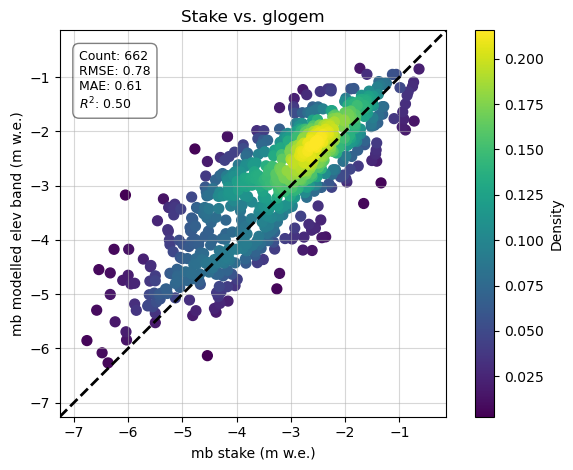

In [205]:
# TEST PLOT
plot_point_modelled(df_test_summer, 'glogem', 1980, 2019)

## Get ML-model predictions

In [207]:
with open('Training_cluster/2024-07-10_20-37-03/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

best_model = clf_loaded.best_estimator_

In [244]:
test_pred = best_model.predict(X_test)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


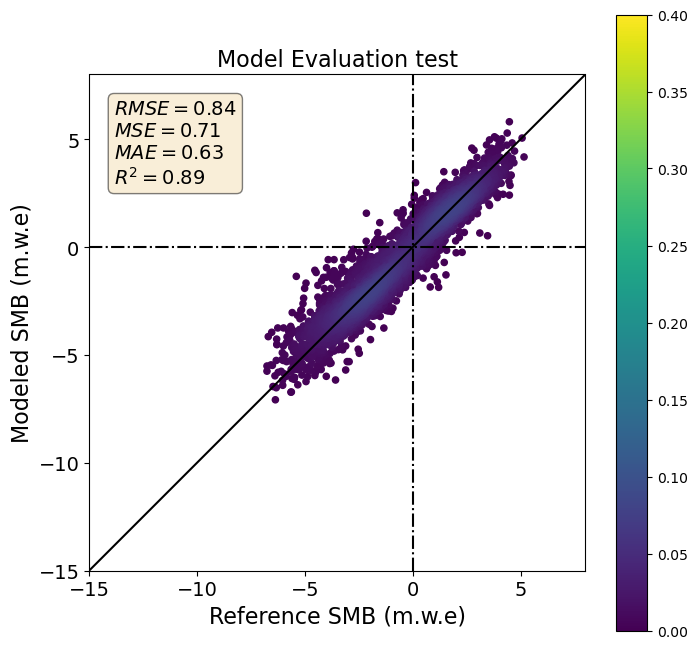

In [245]:
# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

In [246]:
def get_prediction_per_season_test(X_test, y_test, best_model, months=12):

    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test[:,-2] == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    return y_test_crop, y_pred_crop

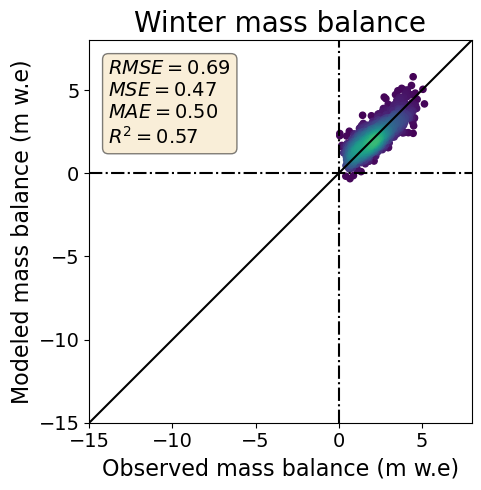

In [247]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

In [248]:
df_test_winter['mb_ML'] = y_pred_winter_agg


In [249]:
df_test_winter

,BREID,year,altitude_diff,altitude,altitude_climate,balance,aspect,slope,n_months,t2m,...,slhf,ssrd,fal,str,tp,ID,mb_glogem,mb_oggm,mb_pygem,mb_ML
0,54.0,2013,-129.772081,471.0,341.227919,1.32,0.629597,0.278773,7.0,266.705911,...,62438.500000,3.477078e+06,0.749392,-2.148801e+06,0.003397,1258,1.226,1.860691,1.783696,0.953359
1,54.0,2014,-97.772081,439.0,341.227919,1.68,0.585924,0.296590,7.0,267.740727,...,65465.714286,3.052352e+06,0.758143,-2.145037e+06,0.003847,1258,NaN,1.774117,NaN,1.060769
2,54.0,2015,-102.772081,444.0,341.227919,0.76,0.663261,0.302508,7.0,267.579795,...,21334.214286,3.186665e+06,0.750785,-2.258321e+06,0.002979,1258,1.055,1.406554,NaN,0.505238
3,54.0,2016,-102.772081,444.0,341.227919,0.78,0.663261,0.302508,7.0,267.811977,...,102229.642857,3.540237e+06,0.771447,-2.084224e+06,0.003243,1258,0.773,1.752640,NaN,0.891115
4,54.0,2017,-126.772081,468.0,341.227919,1.59,0.836757,0.309196,7.0,268.226903,...,64772.571429,3.494867e+06,0.679859,-2.391737e+06,0.003806,1258,1.073,1.887695,NaN,1.384670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3141.0,2012,-160.580241,1078.0,917.419759,1.50,2.906044,0.131717,7.0,270.836827,...,-171713.642857,4.804682e+06,0.683440,-1.769234e+06,0.010046,2969,1.795,3.112298,NaN,1.942014
996,3141.0,2013,-160.580241,1078.0,917.419759,1.14,2.906044,0.131717,7.0,267.233730,...,-123023.142857,5.492646e+06,0.711911,-2.165743e+06,0.006262,2969,1.639,2.114065,NaN,1.447810
997,3141.0,2015,-161.580241,1079.0,917.419759,1.19,2.906044,0.131717,7.0,271.190260,...,-271647.642857,4.664342e+06,0.653273,-1.837262e+06,0.011195,2969,1.681,2.945806,NaN,2.139735
998,3141.0,2016,-160.580241,1078.0,917.419759,1.72,2.906044,0.131717,7.0,270.403787,...,-251040.928571,5.058185e+06,0.655849,-1.987646e+06,0.009280,2969,2.123,2.917965,NaN,1.980113


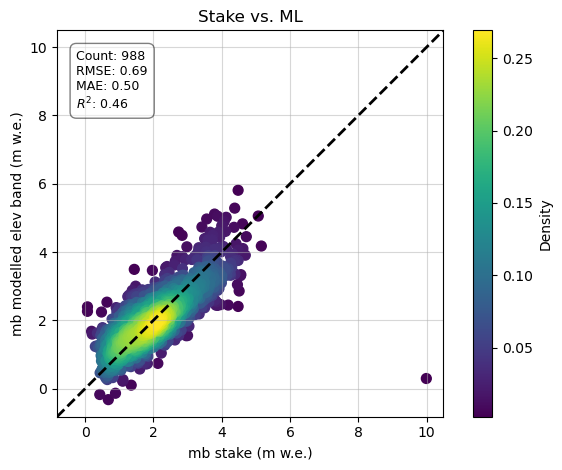

In [256]:
plot_point_modelled(df_test_winter, 'ML', 1960, 2020)

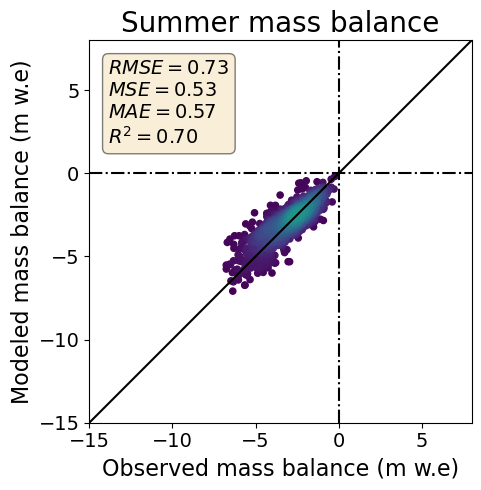

In [251]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

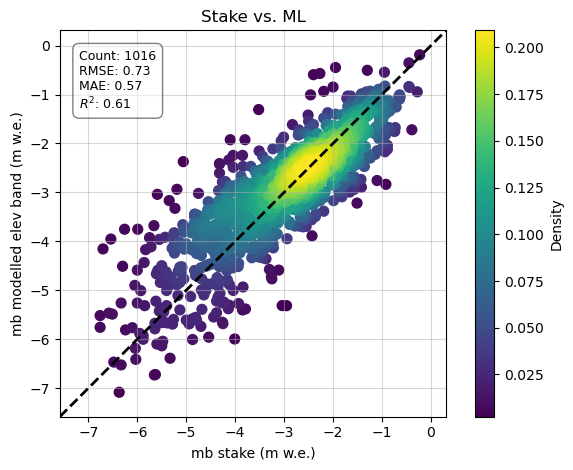

In [254]:
df_test_summer['mb_ML'] = y_pred_summer_agg
plot_point_modelled(df_test_summer, 'ML', 1960, 2020)

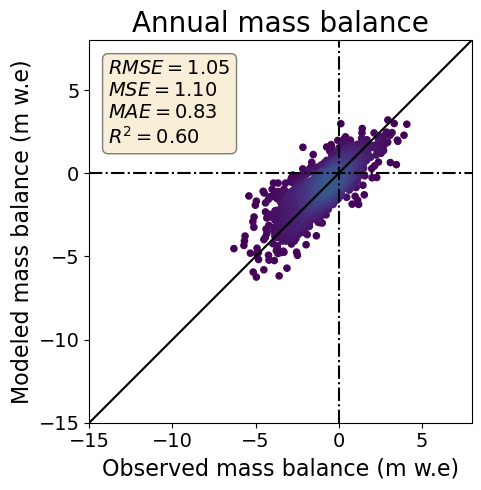

In [223]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

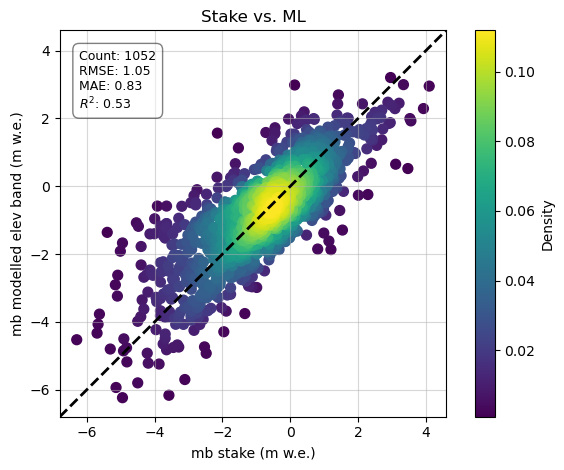

In [257]:
df_test_annual['mb_ML'] = y_pred_annual_agg
plot_point_modelled(df_test_annual, 'ML', 1960, 2020)

## Plot all models

In [272]:
# Plot modelled and observed point mass balances

def plot_point_modelled_subplot(df, model, start_yr, end_yr, ax, min_val=None, max_val=None):
    """
    df : pd.Dataframe of point mb
    type : str, variable in ds; 'netto', 'summer' or 'winter'
    model : str, model name; 'glogem', 'oggm', 'pygem'
    ax: matplotlib Axes object for the subplot
    min_val: float, minimum value for xlim and ylim
    max_val: float, maximum value for xlim and ylim
    """

    df_clean_dropna = df.dropna(subset=['mb_'+model])
    df_clean = df_clean_dropna[(df_clean_dropna['year'] >= start_yr) & (df_clean_dropna['year'] <= end_yr)]

    y_data = df_clean['mb_'+model]
    x_data = df_clean['balance']
    
    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)

    df_with_density = pd.DataFrame({
        'x': x_data,
        'y': y_data,
        'z': z
    })

    df_with_density.sort_values('z', inplace=True)

    scatter = ax.scatter(df_with_density['x'], df_with_density['y'], c=df_with_density['z'], s=50, cmap='viridis')

    if min_val is None:
        min_val = min(x_data.min(), y_data.min()) - 0.5
    if max_val is None:
        max_val = max(x_data.max(), y_data.max()) + 0.5
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('mb stake (m w.e.)')
    ax.set_ylabel('mb modelled elev band (m w.e.)')
    ax.set_title('Stake vs. ' + model)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_data, x_data))
    mae = mean_absolute_error(y_data, x_data) 
    r2 = r2_score(y_data, x_data) 
    count = len(x_data)  # Count the number of data points
    
    stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    
    plt.colorbar(ax.collections[0], ax=ax, label='')
    ax.grid(alpha=0.5)

In [273]:
def plot_all_models(df, models, start_year, end_year, min_val=None, max_val=None):
    """
    df: DataFrame containing the data
    models: List of model names to plot
    start_year: Start year for filtering data
    end_year: End year for filtering data
    min_val: float, override for min value for xlim and ylim
    max_val: float, override for max value for xlim and ylim
    """
    
    # Create a figure with 4 subplots in one row
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), squeeze=False)
    
    for i, model_name in enumerate(models):
        ax = axs[0, i]  # Access each subplot
        plot_point_modelled_subplot(df, model_name, start_year, end_year, ax, min_val=min_val, max_val=max_val)
        
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

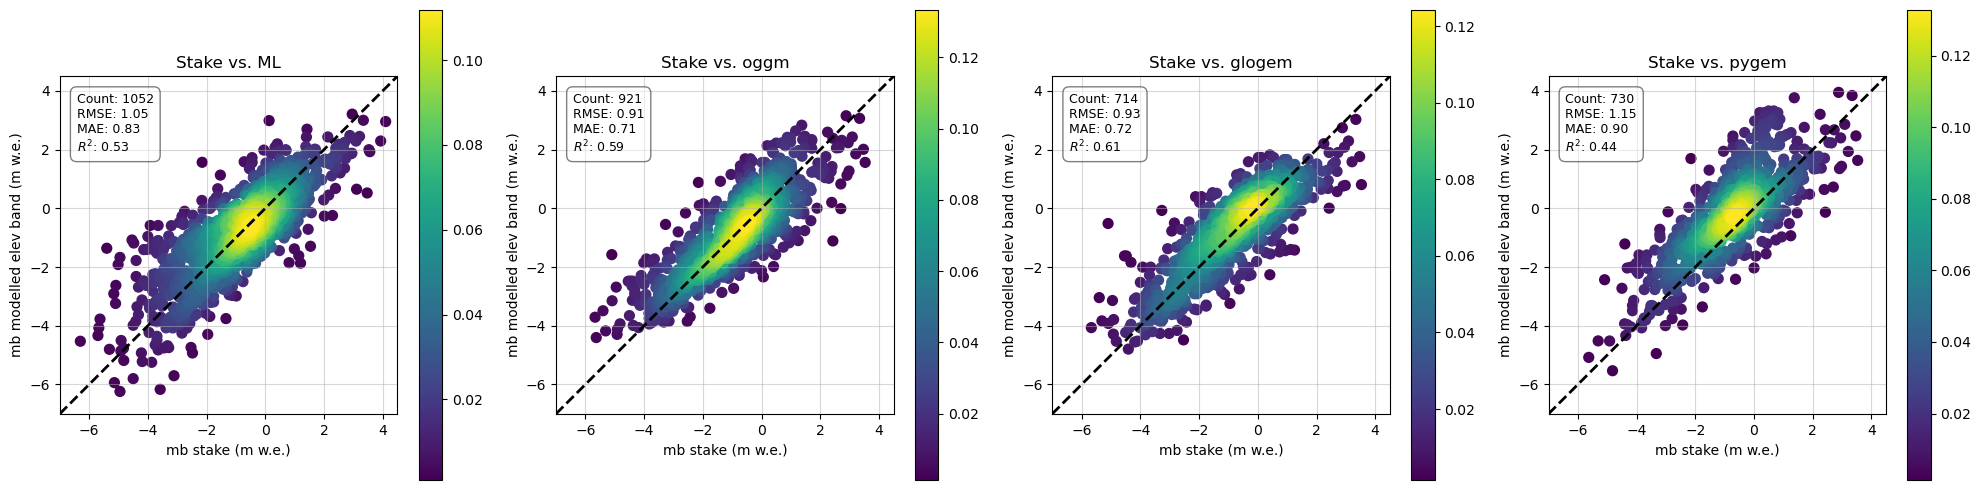

In [274]:
# List of model names
models = ['ML', 'oggm', 'glogem', 'pygem']

# Generate the plot
plot_all_models(df_test_annual, models, 1960, 2020, min_val=-7, max_val=4.5)

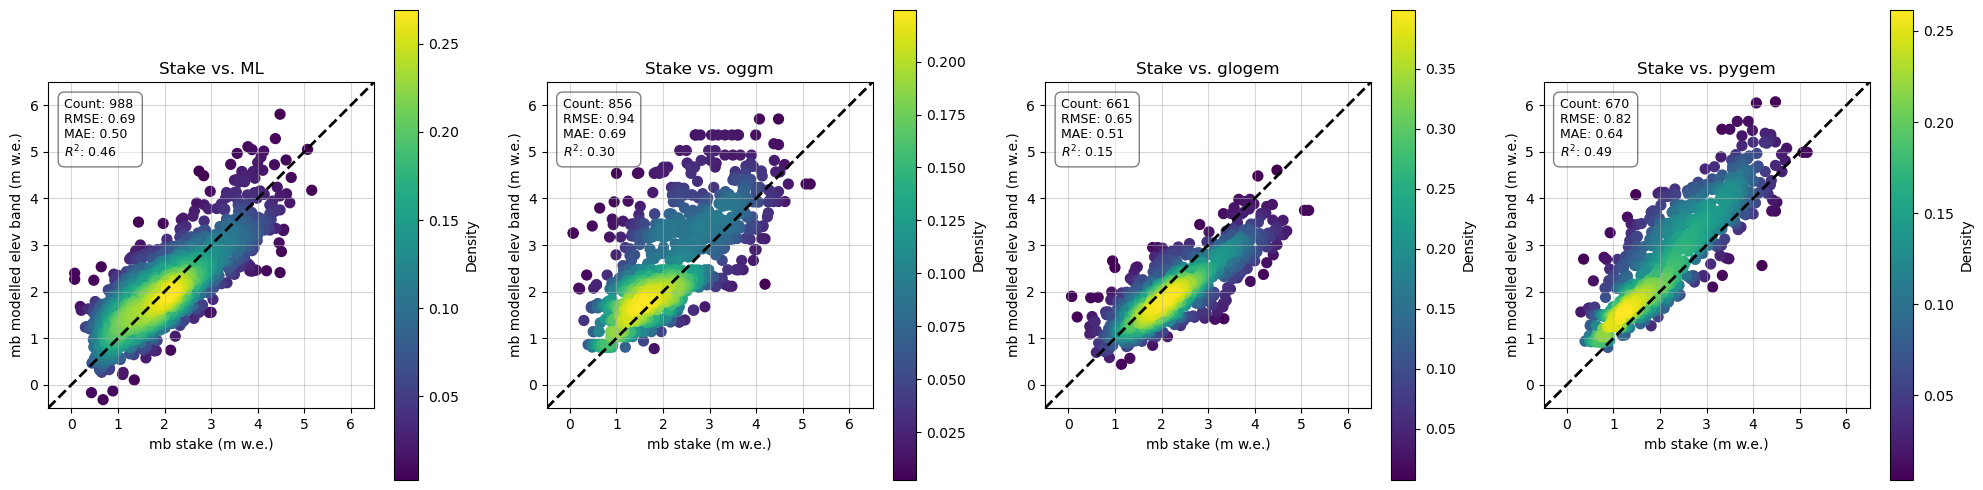

In [268]:
# Generate the plot
plot_all_models(df_test_winter, models, 1960, 2020, min_val=-0.5, max_val=6.5)

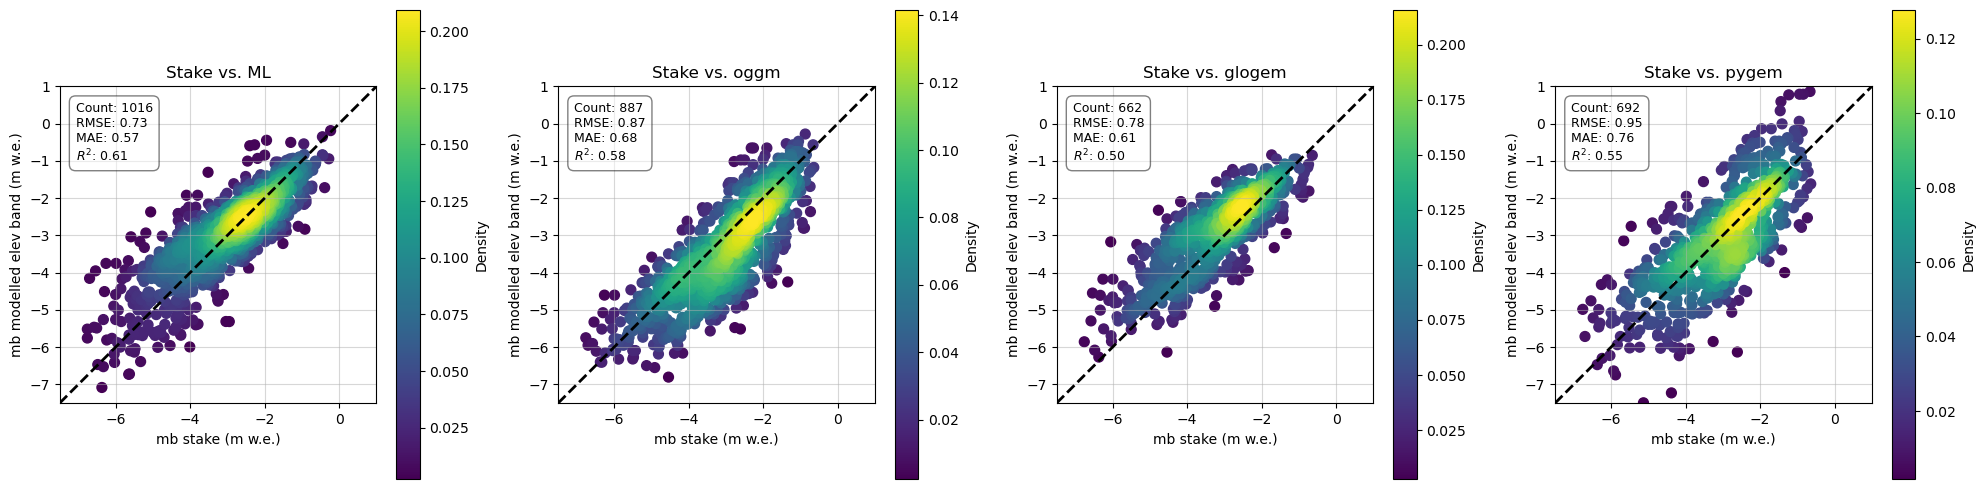

In [269]:
# Generate the plot
plot_all_models(df_test_summer, models, 1960, 2020, min_val=-7.5, max_val=1)